# Training Time Series Classifiers Based on Deep Learning
<strong>Abraham C. Montes</strong> <br>
<a href="https://www.linkedin.com/in/abraham-c-montes-6661a841/">LinkedIn</a>|<a href="https://www.abraham-montes.com/">Personal Site</a><br>
The University of Texas at Austin | <a href="https://drilling.utexas.edu/">RAPID research consortium</a>


<strong> Description: </strong> <br>
The objective of this notebook is to train time-series classifiers based on deep learning for rig/well activity identification. The models implemented here are of two types: An LSTM recurrent neural network and a transformer for time series classification. Both models are constructed using the PyTorch library and leverage GPU hardware for faster, more efficient training.

In [1]:
import logging

class LoggerDev:

    def __init__( self,verbosity=2 ):
      for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
      logging.basicConfig(   format='[%(levelname)s]......... %(message)s', level=logging.DEBUG   )
      self.verbosity      =   verbosity

    def setVerbosity( self,verbosity ):
        self.verbosity      = verbosity
        logging.info( f"Verbosity has been set to {verbosity}" )

    def dbgMsg( self,msg=None ):
        if (msg is not None) and (self.verbosity>1):
            logging.debug(  msg  )

    def infoMsg( self,msg=None ):
        if (msg is not None) and (self.verbosity>1):
            logging.info(  msg  )

    def warningMsg( self,msg=None ):
        if (msg is not None) and (self.verbosity>0):
            logging.warning(  msg  )

    def errorMsg( self,msg=None ):
        if (msg is not None) and (self.verbosity>-1):
            logging.error(  msg  )

    def resultMessage( self,msg=None ):
        if (msg is not None) and (self.verbosity>1):
            logging.info(  f"[RESULTS] -------->  {msg}"  )



In [2]:
class Nomenclature:

    DATE_MNEMONIC           = "Date"
    BIT_DEPTH_MNEMO         = "Bit Depth [ft]"
    DEPTH_MNEMONIC          = "Measured Depth [ft]"
    DEPTH_MNEMONIC_METRIC   = "Measured Depth [m]"
    TORTUOSITY_MNEMO        = "Tortuosity Idx"
    INCLINATION_MNEMO       = 'Inclination [°]'
    AZIMUTH_MNEMO           = 'Azimuth [°]'
    DLS_MNEMO               = 'DLS [°/100 ft]'
    GAMMA_RAY_LOG_MNEMO     = "Gamma Ray [API]"
    ROP_MNEMO               = "ROP [fph]"
    TORQUE_MNEMO            = "Torque [lb-ft]"
    WOB_MNEMO               = "Weight on Bit [klb]"
    STANDPIPE_PRESSURE_MNEMO="Standpipe Pressure [psi]"
    RPM_MNEMO               = "Surface Rotation [rpm]"
    HOOK_LOAD_MNEMO         = "Hook Load [klb]"
    HOLE_DEPTH_MNEMO        = "Hole Depth [ft]"
    FLOW_IN_MNEMO           = "Flow In [gpm]"
    BLOCK_POSITION_MNEMO    = "Block Position [ft]"
    RIG_STATE_MNEMO         = "Rig State"
    RIG_ACTIVITY_MNEMO      = "Activity"
    SECTION_PHASE_MNEMO     = "Section Operation Phase"
    TORTUOSITY_BIT_MNEMO    = 'Tortuosity Idx at Bit'
    FLEX_RIGIDITY_BIT_MNEMO = 'Flex Rigidity Difference at Bit'
    BLOCK_WEIGHT_MNEMO      = 'Block Weight [klb]'
    TRIP_OUT_MNEMO          = "Trip Out"
    DRILLING_MNEMO          = "Drilling"
    CIRCULATION_MNEMO       = "Circulation"
    BLOCK_WEIGHT_DELTA_MNEMO= "delta"
    BLOCK_WEIGHT_DELTA_DATES_MNEMO="dates"
    HOOK_LOAD_MEAN_MNEMO    = 'Effective Hook Load Mean'
    PRESSURE_MEAN_MNEMO     = 'Standpipe Pressure Mean'
    BLOCK_POSITION_TREND_MNEMO='Block Position Trend'
    FLOW_RATE_VARIABILITY_MNEMO='Flow Rate Variability'
    FLOW_RATE_MEAN_MNEMO        ='Flow Rate Mean'
    RPM_MEAN_MNEMO          = 'RPM Mean'
    HOOK_LOAD_MEAN_MNEMO    = 'Hook Load Mean'
    HOOK_LOAD_VARIABILITY_MNEMO='Hook Load Variability'
    EFF_HOOK_LOAD_MNEMO     = 'Effective Hook Load [klb]'
    ROP_MEAN_MNEMO          = 'ROP Mean'
    BLOCK_POSITION_TREND_SHORT_MNEMO='Short-Term Block Position Trend'
    BLOCK_POSITION_TREND_IT1_MNEMO='Intermediate-Term 1 Block Position Trend'
    BLOCK_POSITION_TREND_IT2_MNEMO='Intermediate-Term 2 Block Position Trend'
    BLOCK_POSITION_TREND_LONG_MNEMO='Long-Term Block Position Trend'
    HOOK_LOAD_SHORT_TREND='Short-Term Effective Hook Load Trend'
    HOOK_LOAD_TREND_IT1_MNEMO='Intermediate-Term 1 Effective Hook Load Trend'
    HOOK_LOAD_TREND_IT2_MNEMO='Intermediate-Term 2 Effective Hook Load Trend'
    HOOK_LOAD_LONG_TREND='Long-Term Effective Hook Load Trend'

    BACKREAMING_MNEMO       = 117
    TRIP_OUT_ELEV_MNEMO     = 112
    PUMPING_OUT_MNEMO       = 115
    REAMING_MNEMO           = 116
    DRILLING_ROT_MNEMO      = 119
    CONNECTION_MNEMO        = 118
    TRANSFORMER_MODEL_MNEMO = "transformer"
    LSTM_MODEL_MNEMO        = "lstm"
    CONV_LSTM_MODEL_MNEMO  = "conv_lstm"
    CONV_TRANSFORMER_MODEL_MNEMO="conv_transformer"
    GOAL_RIG_STATES         = [111,112,114,115,116,117,118,119,120,121,124]
    DICT_RIG_STATES         = {
                                    111:"Tripping in on elevators",
                                    112:"Tripping out on elevators",
                                    114:"Washing down",
                                    115:"Pumping out",
                                    116:"Reaming",
                                    117:"Backreaming",
                                    118:"Drillstring set in the slips",
                                    119:"Drilling (with surface rotation)",
                                    120:"Drilling (sliding)",
                                    121:"Circulating",
                                    124:"Static, off-the-slips drillstring"
                                }
    CONVERTION_HASH_TABLE   = {
            "TIME":                             DATE_MNEMONIC,
            "DBTM":                             BIT_DEPTH_MNEMO,
            "BPOS":                             BLOCK_POSITION_MNEMO,
            "MFIA":                             FLOW_IN_MNEMO,
            "DMEA":                             HOLE_DEPTH_MNEMO,
            "HKLA":                             HOOK_LOAD_MNEMO,
            "RPMA":                             RPM_MNEMO,
            "SPPA":                             STANDPIPE_PRESSURE_MNEMO,
            "WOBA":                             WOB_MNEMO,
            "TQA":                              TORQUE_MNEMO,
            # "ROPA__":                           ROP_MNEMO,
            #Note (10/21/24): For some unknown issue within Shell's system, the 'ROPA__' channel
            # is sometimes unavailable (full with NaNs). An alternative is the one below.
            "ROPA__SHELL_CALCULATION_INPUT_TIME":ROP_MNEMO,
            "MD":                               DEPTH_MNEMONIC,
            "INCLINATION":                      INCLINATION_MNEMO,
            "AZIMUTH":                          AZIMUTH_MNEMO,
            "DLS":                              DLS_MNEMO,
            "DEPTH":                            DEPTH_MNEMONIC,
            "SGRC":                             GAMMA_RAY_LOG_MNEMO
        }



In [19]:
import torch
import torch.nn as nn
import numpy as np

class TimeSeriesTransformer( nn.Module ):

    def __init__( self, nInputs,dModel,nHead,nLayers,dimFeedForward,nOutput,dropoutRate=0.1 ):
        super( TimeSeriesTransformer,self ).__init__( )
        self.D                  = nInputs
        self.dModel             = dModel
        self.inputProjection    = nn.Linear(  nInputs, dModel  )
        self.posEncoding        = nn.Parameter( self._generatePosEncoding( dModel, maxLength=300 ), requires_grad=False )
        encoderLayer            = nn.TransformerEncoderLayer( d_model=dModel, nhead=nHead, dim_feedforward=dimFeedForward, dropout=dropoutRate )
        self.transformerEncoder = nn.TransformerEncoder(encoderLayer, num_layers=nLayers)
        self.fc                 = nn.Linear( dModel, nOutput  )
        self.softmax            = nn.Softmax( dim=1 )

    def _generatePosEncoding(  self, dModel, maxLength  ):
        position                = torch.arange(  0, maxLength  ).unsqueeze(1)
        divTerm                 = torch.exp(torch.arange(  0, dModel, 2) * -(np.log(10000.0) / dModel)  )
        posEncoding             = torch.zeros(  maxLength, dModel  )
        posEncoding[ :, 0::2 ]    = torch.sin(  position * divTerm  )
        posEncoding[ :, 1::2 ]    = torch.cos(  position * divTerm  )
        return posEncoding.unsqueeze( 0 )

    def forward( self, x ):
        x                       = self.inputProjection( x )
        x                       = x + self.posEncoding[ :, :x.size(1), : ]
        x                       = x.permute(1, 0, 2)
        x                       = self.transformerEncoder( x )
        x                       = x[ -1, :, : ]
        output                  = self.fc( x )
        return self.softmax( output )

In [20]:

class LSTMClassifier( nn.Module ):
    def __init__( self, nInputs,nHidden,nLayers,nOutput ):
        super( LSTMClassifier,self ).__init__( )
        self.D  = nInputs
        self.M  = nHidden
        self.K  = nOutput
        self.L  = nLayers

        self.lstm           = nn.LSTM(
                                            input_size      =self.D,
                                            hidden_size     =self.M,
                                            num_layers      =self.L,
                                            batch_first     =True
                                        )
        self.fc             = nn.Linear( self.M,self.K )

    def forward( self,x ):
        out, (hn, cn)       = self.lstm( x )
        out                 = self.fc( hn[ -1 ] )
        return out

In [21]:
class ConvLSTMClassifier( nn.Module ):
    def __init__( self, nInputs,nHidden,nLayers,nOutput,convOutChannels=32,kernelSize=3,poolingSize=2 ):
        super( ConvLSTMClassifier,self ).__init__( )
        self.D  = nInputs
        self.M  = nHidden
        self.K  = nOutput
        self.L  = nLayers

        self.conv           = nn.Conv1d(
            in_channels     =nInputs,       
            out_channels    =convOutChannels, 
            kernel_size     =kernelSize,    
            padding         =kernelSize // 2  
        )

        self.pool = nn.MaxPool1d(  kernel_size=poolingSize, stride=poolingSize  )

        self.lstmInputSize = convOutChannels

        self.lstm           = nn.LSTM(
                                            input_size      =self.lstmInputSize,
                                            hidden_size     =self.M,
                                            num_layers      =self.L,
                                            batch_first     =True
                                        )
        self.fc             = nn.Linear( self.M,self.K )

    def forward( self,x ):
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        out, (hn, cn)       = self.lstm( x )
        out                 = self.fc( hn[ -1 ] )
        return out

class ConvTimeSeriesTransformer( nn.Module ):

    def __init__( self, nInputs,dModel,nHead,nLayers,dimFeedForward,nOutput,dropoutRate=0.1,kernelSize=3 ):
        super( ConvTimeSeriesTransformer,self ).__init__( )
        self.D                  = nInputs
        self.dModel             = dModel
        self.conv               = nn.Conv1d( in_channels=nInputs,out_channels=dModel,kernel_size=kernelSize,padding=(kernelSize-1) // 2 )
        self.posEncoding        = nn.Parameter( self._generatePosEncoding( dModel, maxLength=1000 ), requires_grad=False )
        encoderLayer            = nn.TransformerEncoderLayer( d_model=dModel, nhead=nHead, dim_feedforward=dimFeedForward, dropout=dropoutRate )
        self.transformerEncoder = nn.TransformerEncoder(encoderLayer, num_layers=nLayers)
        self.fc                 = nn.Linear( dModel, nOutput  )

    def _generatePosEncoding(  self, dModel, maxLength  ):
        position                = torch.arange(  0, maxLength  ).unsqueeze(1)
        divTerm                 = torch.exp(torch.arange(  0, dModel, 2) * -(np.log(10000.0) / dModel)  )
        posEncoding             = torch.zeros(  maxLength, dModel  )
        posEncoding[ :, 0::2 ]    = torch.sin(  position * divTerm  )
        posEncoding[ :, 1::2 ]    = torch.cos(  position * divTerm  )
        return posEncoding.unsqueeze( 0 )

    def forward( self, x ):
        x                       = x.permute( 0,2,1 )
        x                       = self.conv( x )
        x                       = x.permute( 0,2,1 )
        x                       = x + self.posEncoding[ :, :x.size(1), : ]
        x                       = x.permute( 1,0,2 )
        x                       = self.transformerEncoder( x )
        x                       = x[ -1, :, : ]
        output                  = self.fc( x )
        return output


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy as sp
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
import sys
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
import joblib

class Trainer:

    FDICT_PLOTS                 = {'family':'Arial','size':8}
    LOWER_LIM_HKL_FOR_BLOCK_WEIGHT      = 100
    UPPER_LIM_HKL_FOR_BLOCK_WEIGHT      = 1000
    WINDOW_BLOCK_POS_TREND              = 3

    def __init__( self ):
        """
        slidingWindow:          Time windows to derive features. For example, the trend of the block position. 
                                It is a list. The first component is a small time window, to emphasize short-term changes. 
                                The second one is a large time window, to account for long-term variations.
        slidingWindowCoverage:  Time window of size T used to convert the extracted features from a NxD matrix to a NxTxD, where T is the size of the subsequences
                                that the model will use as inputs.
        """
        self.logger             = LoggerDev(  )
        self.dataSets           = [  ]
        self.concatDataset      = [  ]
        self.blockWeights       = [  ]
        self.nom                = Nomenclature(  )
        self.labelPreds         = {  }
        self.scaler             = StandardScaler( )
        self.slidingWindow= None
        self.slidingWindowCoverage= None

    def setSlidingWindow( self,slidingWindows ):
        self.slidingWindow      = slidingWindows

    def setSlidingWindowCoverage( self,slidingWindowCoverage ):
        self.slidingWindowCoverage      = slidingWindowCoverage
#changed
    def loadData( self,pathFolder,blockWeights={  },nBinsBWInference=100,dropNaNs=True,preloadedDF=None ):
        if preloadedDF is None:
            for file in os.listdir( pathFolder ):
                if file==".ipynb_checkpoints":  continue
                df                                  = pd.read_csv( pathFolder+"/"+file,parse_dates=[ self.nom.DATE_MNEMONIC ],na_values=[-999.25] )
                if dropNaNs:                        df                                  = df.dropna( axis=0 )
                if file[ :-4 ] in list( blockWeights.keys(  ) ):
                    bW                              =   blockWeights[ file[ :-4 ] ]
                else:
                    bW                              =   self._getBlockWeight( df,nbins=nBinsBWInference )
                    self.logger.warningMsg( f"The block weight for the {file[ :-4 ]} well was not provided. Therefore, it has been inferred. Its value is: {bW:.1f}" )
                df[ self.nom.BLOCK_WEIGHT_MNEMO ]   = bW
                self.dataSets.append( df )
                self.blockWeights.append( bW )
                self.logger.infoMsg( f"Block weight for {file} has been set on: {bW:.1f} klb." )
            self.logger.infoMsg( f"Data has been loaded correctly to the trainer. In total, {len( self.dataSets )} dataframes have been loaded." )
        else: 
            if self.nom.BLOCK_WEIGHT_MNEMO in list( preloadedDF.columns ):
                self.dataSets.append( preloadedDF )
                self.blockWeights.append( preloadedDF[self.nom.BLOCK_WEIGHT_MNEMO].iloc[0] )
                self.logger.infoMsg( f"Loaded provided dataframe sucessfully." )
            else:
                self.logger.errorMsg( f"The provided DF does not contain the block weight. Please include it before loading." )
                sys.exit( 1 )
            

    def _loadCheckPoint( self, currentCheckPointPath, model, optimizer ):
        checkpoint                              = torch.load(  currentCheckPointPath, weights_only=False  )
        model.load_state_dict(  checkpoint['model_state_dict']  )
        optimizer.load_state_dict(  checkpoint['optimizer_state_dict']  )
        return model, optimizer

    def trainModel(  self, modelType, batchSize=32, nEpochs=200, learningRate=0.0001, currentCheckPointPath=None,
                    saveModel=True, savePath="model_transformer.pth", saveScaler=True, scalerPath="scaler_transformer",
                     stratifyData=True,fitScaler=True, **kwargs  ):
        if len( self.dataSets )==0:
            self.logger.errorMsg( "No data has been loaded to the trainer. Use the loadData( ) function before training a model." )
            sys.exit( 1 );
        model, optimizer        = self._createModel( modelType,learningRate, **kwargs )
        self.logger.infoMsg( f"The {modelType} model has been created." )
        currEpoch               = 0
        trainLosses             = np.zeros( nEpochs )
        decorators1          = "default_hiddens" if "nHidden" not in kwargs else f"H{kwargs['nHidden']}"
        # decorators1          = "default_heads" if "nHeads" not in kwargs else f"H{kwargs['nHeads']}"
        decorators2          = "default_layers" if "nLayers" not in kwargs else f"L{kwargs['nLayers']}"
        if 'slidingWindow' not in kwargs:
            self.slidingWindow  = [5,30]
            self.logger.warningMsg( f"The size of the sliding windows (two resolution levels) has not been specified. By default, the small time window has been set on {self.slidingWindow[0]} sec, and the large one to {self.slidingWindow[1]} sec." )
        else: self.slidingWindow= kwargs['slidingWindow']
        if 'slidingWindowCoverage' not in kwargs:
            self.slidingWindowCoverage  = 5
            self.logger.warningMsg( f"The size of the transformation window has not been specified. By default, it has been set on {self.slidingWindowCoverage}." )
        else: self.slidingWindowCoverage= kwargs['slidingWindowCoverage']
        if currentCheckPointPath is not None:
            model, optimizer    = self._loadCheckPoint( currentCheckPointPath, model, optimizer )
            self.logger.infoMsg( "Checkpoint loaded successfully. Resuming training..." )
        else:                   self.logger.infoMsg( "Starting training..." )
        device                  = torch.device( "cuda:0" if torch.cuda.is_available( ) else "cpu" )
        typeDevice              = "GPU" if torch.cuda.is_available( ) else "CPU"
        self.logger.infoMsg(  f"Working on: {typeDevice}, model {torch.cuda.get_device_name(0)}"  )
        self.logger.infoMsg( "Extracting features for dataset No. 1." )
        X_train, y_train        = self.extractFeatures( self.dataSets[ 0 ],self.blockWeights[ 0 ],modelType=modelType,slidingWindow=self.slidingWindow,fitScaler=fitScaler )
        if len( self.dataSets )>1:
            for k,ds in enumerate( self.dataSets[1:] ):
                self.logger.infoMsg( f"Extracting features for dataset No. {k+2}." )
                X_train_temp, y_train_temp  = self.extractFeatures( ds,self.blockWeights[ k+1 ],modelType=modelType,slidingWindow=self.slidingWindow,fitScaler=fitScaler )
                X_train         = np.concatenate( [X_train,X_train_temp],axis=0 )
                y_train         = np.concatenate( [y_train,y_train_temp] )
        self.logger.infoMsg( f"The training dataset has the following shape: {X_train.shape[0]} X {X_train.shape[1]}. The response: {y_train.shape}" )
        X_train                 = self.scaler.transform( X_train )
        X_train, y_train        = self.wrapTensor( X_train,y_train,slidingWindow=self.slidingWindowCoverage )
        nNans                   = np.isnan( X_train ).sum(  )
        if nNans>0:             self.logger.warningMsg( f"There are {nNans} NaNs in the training dataset. Consider trimming NaNs before training." )
        X_train, y_train        = self._stratifyData( X_train, y_train,stratify=stratifyData )
        X_train                 = torch.from_numpy( X_train.astype(np.float32) ).to( device )
        y_train                 = torch.from_numpy( y_train.astype(np.float32) )
        y_train                 = torch.argmax( y_train, dim=1 ).to( device )
        self.logger.infoMsg( f"Size of the training data: {(X_train.numel(  ) * X_train.element_size(  ))/1E9:.2f} GB for the input matrix and {(y_train.numel(  ) * y_train.element_size(  ))/1E9:.2f} GB for the response variable." )
        if saveScaler:
            joblib.dump( self.scaler, f"{scalerPath}_SW{self.slidingWindow[0]}_{self.slidingWindow[1]}_SW{self.slidingWindow[0]}_{self.slidingWindow[1]}CV{self.slidingWindowCoverage}_{decorators1}_{decorators2}.pkl" )
            self.logger.infoMsg( f"Successfully saved scaler: {scalerPath}" )
        criterion               = nn.CrossEntropyLoss(  )
        dataset                 = TensorDataset( X_train, y_train )
        dataLoader              = DataLoader( dataset, batch_size=batchSize, shuffle=True )
        self.logger.infoMsg( "Data loaded to the torch DataLoader object." )
        for epoch in range( nEpochs ):
            if epoch==0: self.logger.infoMsg( f"Initiating forward pass (epoch {epoch})." )
            model.train(  )
            runningLoss         = 0.0
            correctPreds        = 0
            totalPreds          = 0
            for batchNo, ( inputs, labels ) in enumerate( dataLoader ):
                if batchNo%150==0:self.logger.infoMsg( f'[LOADER>>>]..... Processing batch No. {batchNo}.')
                optimizer.zero_grad(  )
                outputs         = model( inputs )
                loss            = criterion( outputs, labels )
                loss.backward(  )
                optimizer.step(  )
                runningLoss     += loss.item(  )
                _, predicted    = torch.max( outputs, 1 )
                correctPreds    += ( predicted == labels ).sum(  ).item(  )
                totalPreds      += labels.size( 0 )
            epochLoss               = runningLoss / len(  dataLoader  )
            trainLosses[ epoch ] = epochLoss
            self.logger.infoMsg( f'[TRAINING MSG>>>]..... Epoch {epoch+1}/{nEpochs}, Train Loss: {loss.item(  ):.4f}')
            self._saveCheckpoint( model,optimizer,epoch,trainLosses[-1],modelType,codeName=f"_{decorators1}_{decorators2}_SW{self.slidingWindow[0]}_{self.slidingWindow[1]}_SWC{self.slidingWindowCoverage}" )
            self.logger.infoMsg( f"Successfully saved checkpoint: {modelType}.chpt" )
        if saveModel:
            torch.save(  model.state_dict(  ), savePath  )
            self.logger.infoMsg( f"Successfully saved {modelType} model: {savePath}" )
        return trainLosses, model
    
    def _stratifyData( self,X,y,stratify,nUndersamplingRounds=2 ):
        if not stratify:    return X,y
        yComp                   = np.argmax( y,axis=1 )
        self.logger.infoMsg( f"The number of unique classes are: {len(np.unique(yComp))}" )
        countDict                   = { x:np.sum( yComp==x ) for x in np.unique( yComp ) }
        self.logger.infoMsg( f"Before undersampling, the counts per class are: {countDict}." )
        newX,newY               = ( X,y )
        newX,newY,countDict     = self._undersampling( newX,newY,nTimes=nUndersamplingRounds )
        self.logger.infoMsg( f"After undersampling, the counts per class are: {countDict}." )
        return newX,newY    
    
    def _undersampling( self,newX,newY,nTimes=2 ):
        buffX,buffY             = ( newX,newY )
        for i in range( nTimes ):
            yComp                   = np.argmax( buffY,axis=1 )
            countDict               = { x:np.sum( yComp==x ) for x in np.unique( yComp ) }
            classRef                = sorted( countDict,key=countDict.get,reverse=True )[i]
            classRefNext            = sorted( countDict,key=countDict.get,reverse=True )[i+1]
            diff                    = countDict[classRef] - countDict[classRefNext]
            rdSetDelete             = np.array( [ ] )
            for jClass in sorted( countDict,key=countDict.get,reverse=True )[0:i+1]:
                indices             = np.argwhere( yComp==jClass ).reshape( -1, )
                selection           = np.random.choice( indices, size=diff, replace=False )
                rdSetDelete         = np.concatenate( [ rdSetDelete,selection ] )
            allIdxs                 = np.setdiff1d( np.arange( buffX.shape[0] ), rdSetDelete ).astype( int )
            buffX                    = buffX[ allIdxs ]
            buffY                    = buffY[ allIdxs ]
        yComp                       = np.argmax( buffY,axis=1 )
        countDict                   = { x:np.sum( yComp==x ) for x in np.unique( yComp ) }
        return buffX,buffY,countDict

    def wrapTensor( self,X,y,slidingWindow ):
        XF                      = [ ]
        yF                      = [ ]
        for t in range( X.shape[ 0 ]-slidingWindow ):
            x                   = X[ t:t+slidingWindow,: ]
            XF.append( x )
            ny                  = y[ t+slidingWindow-1,: ]
            yF.append( ny )
        XF                      = np.array( XF ).reshape( -1,slidingWindow,X.shape[1] )
        yF                      = np.array( yF ).reshape( -1,y.shape[1] )
        # if modelType=="lstm":
        #     y_train                 = torch.from_numpy(yF.astype(np.float32)).to( device )
        # else:
        #     y_train                 = torch.from_numpy(yF.astype(np.float32))
        #     y_train                 = torch.argmax( y_train, dim=1 ).to( device )
        return XF.astype(np.float32),yF.astype(np.float32)

    def _getBlockWeight( self,dataSet,nbins=100 ):
        df                      = dataSet.copy( deep=True )
        df[self.nom.HOOK_LOAD_MNEMO]   = np.where( (df[ self.nom.HOOK_LOAD_MNEMO ]<0) | (df[ self.nom.HOOK_LOAD_MNEMO ]>self.UPPER_LIM_HKL_FOR_BLOCK_WEIGHT), 0, df[ self.nom.HOOK_LOAD_MNEMO ])
        b                       = np.flip( np.argsort( np.histogram( df[ self.nom.HOOK_LOAD_MNEMO ],bins=nbins )[0] ) )
        c                       = np.histogram( df[ self.nom.HOOK_LOAD_MNEMO ],bins=nbins )[1][b][  np.histogram( df[ self.nom.HOOK_LOAD_MNEMO ],bins=nbins )[1][b]<self.LOWER_LIM_HKL_FOR_BLOCK_WEIGHT  ]
        delta                   = ( np.histogram( df[ self.nom.HOOK_LOAD_MNEMO ],bins=nbins )[1].max(  ) - np.histogram( df[ self.nom.HOOK_LOAD_MNEMO ],bins=nbins )[1].min(  ) )/(  2*nbins  )
        inferredBW              = c[0]+delta
        return inferredBW

    def extractFeatures( self, df, blockWeight, modelType,slidingWindow=[2,5,10,30],fitScaler=False ):
        if isinstance( slidingWindow,list ):
            if len( slidingWindow )>=2:  #------addednow
                if len( slidingWindow )==2:
                    shortTW,longTW                                          = slidingWindow
                elif len( slidingWindow )==4:
                    shortTW,intTW1,intTW2,longTW                            = slidingWindow
                else:
                    self.logger.errorMsg( "You must provide either two or four time windows for window-based features derivation." )
                    sys.exit( 1 )
            else:
                self.logger.errorMsg( "slidingWindow must be a list with at least two components: The size of the time windows for inspecting short- and long-term variation")
                sys.exit( 1 )
        else:
            self.logger.errorMsg( "slidingWindow must be a list." )
            sys.exit( 1 )
        df[self.nom.EFF_HOOK_LOAD_MNEMO]            = np.where(df[self.nom.HOOK_LOAD_MNEMO]>0,df[self.nom.HOOK_LOAD_MNEMO]-df[self.nom.BLOCK_WEIGHT_MNEMO],0)
        df[self.nom.BLOCK_POSITION_TREND_SHORT_MNEMO]= df[self.nom.BLOCK_POSITION_MNEMO].rolling(window=shortTW).apply(self._trend,raw=True,engine='cython')
        df[self.nom.BLOCK_POSITION_TREND_LONG_MNEMO]= df[self.nom.BLOCK_POSITION_MNEMO].rolling(window=longTW).apply(self._trend,raw=True,engine='cython')
        df[self.nom.HOOK_LOAD_MEAN_MNEMO]           = df[self.nom.EFF_HOOK_LOAD_MNEMO].rolling(window=shortTW).mean(  )
        df[self.nom.HOOK_LOAD_SHORT_TREND]                  = df[self.nom.EFF_HOOK_LOAD_MNEMO].rolling(window=shortTW).apply(self._trend,raw=True,engine='cython')
        df[self.nom.HOOK_LOAD_LONG_TREND]                   = df[self.nom.EFF_HOOK_LOAD_MNEMO].rolling(window=longTW).apply(self._trend,raw=True,engine='cython')
        if len( slidingWindow )==4: #------addednow
            df[self.nom.BLOCK_POSITION_TREND_IT1_MNEMO]     = df[self.nom.BLOCK_POSITION_MNEMO].rolling(window=intTW1).apply(self._trend,raw=True,engine='cython')
            df[self.nom.BLOCK_POSITION_TREND_IT2_MNEMO]= df[self.nom.BLOCK_POSITION_MNEMO].rolling(window=intTW2).apply(self._trend,raw=True,engine='cython')
            df[self.nom.HOOK_LOAD_TREND_IT1_MNEMO]                = df[self.nom.EFF_HOOK_LOAD_MNEMO].rolling(window=intTW1).apply(self._trend,raw=True,engine='cython')
            df[self.nom.HOOK_LOAD_TREND_IT2_MNEMO]                = df[self.nom.EFF_HOOK_LOAD_MNEMO].rolling(window=intTW2).apply(self._trend,raw=True,engine='cython')
        df[self.nom.FLOW_RATE_VARIABILITY_MNEMO]    = df[self.nom.FLOW_IN_MNEMO].rolling(window=shortTW).std(  )
        df[self.nom.FLOW_RATE_MEAN_MNEMO]           = df[self.nom.FLOW_IN_MNEMO].rolling(window=shortTW).mean(  )
        df[self.nom.PRESSURE_MEAN_MNEMO]            = df[self.nom.STANDPIPE_PRESSURE_MNEMO].rolling(window=shortTW).mean(  )
        df[self.nom.RPM_MEAN_MNEMO]                 = df[self.nom.RPM_MNEMO].rolling(window=shortTW).mean(  )
        
        # df[self.nom.HOOK_LOAD_VARIABILITY_MNEMO]    = df[self.nom.EFF_HOOK_LOAD_MNEMO].rolling(window=shortTW).std(  )
        df[self.nom.ROP_MEAN_MNEMO]                 = df[self.nom.ROP_MNEMO].rolling(window=shortTW).mean(  )
        dfAux                   = df.dropna( axis=0 )
        if len( slidingWindow )==4:
            dfTraining                                  = dfAux[[self.nom.BLOCK_POSITION_TREND_SHORT_MNEMO,
                                                            self.nom.BLOCK_POSITION_TREND_LONG_MNEMO,
                                                            self.nom.BLOCK_POSITION_TREND_IT1_MNEMO,
                                                            self.nom.BLOCK_POSITION_TREND_IT2_MNEMO,
                                                                self.nom.FLOW_RATE_VARIABILITY_MNEMO,
                                                                self.nom.FLOW_RATE_MEAN_MNEMO,
                                                                self.nom.PRESSURE_MEAN_MNEMO,
                                                                self.nom.RPM_MEAN_MNEMO,
                                                                self.nom.HOOK_LOAD_MEAN_MNEMO,
                                                                self.nom.ROP_MEAN_MNEMO,
                                                                self.nom.HOOK_LOAD_SHORT_TREND,
                                                                self.nom.HOOK_LOAD_LONG_TREND,
                                                                self.nom.HOOK_LOAD_TREND_IT1_MNEMO,
                                                                self.nom.HOOK_LOAD_TREND_IT2_MNEMO,
                                                                self.nom.RIG_STATE_MNEMO]]
        elif len( slidingWindow )==2:
            dfTraining                                  = dfAux[[self.nom.BLOCK_POSITION_TREND_SHORT_MNEMO,
                                                            self.nom.BLOCK_POSITION_TREND_LONG_MNEMO,
                                                                self.nom.FLOW_RATE_VARIABILITY_MNEMO,
                                                                self.nom.FLOW_RATE_MEAN_MNEMO,
                                                                self.nom.PRESSURE_MEAN_MNEMO,
                                                                self.nom.RPM_MEAN_MNEMO,
                                                                self.nom.HOOK_LOAD_MEAN_MNEMO,
                                                                self.nom.ROP_MEAN_MNEMO,
                                                                self.nom.HOOK_LOAD_SHORT_TREND,
                                                                self.nom.HOOK_LOAD_LONG_TREND,
                                                                self.nom.RIG_STATE_MNEMO]]        
        X                       = dfTraining.iloc[:,:-1].values
        y                       = dfTraining[self.nom.RIG_STATE_MNEMO].values
        y                       = pd.get_dummies( y )
        y                       = y.reindex( columns=self.nom.GOAL_RIG_STATES,fill_value=False )
        y                       = y.values
        if fitScaler:           self.scaler.partial_fit( X )
        return X, y, dfAux
    


    def plotLosses( self, trainingLoss, testLoss, outPath="loss_curve.png" ):
        fig,ax                    = plt.subplots( figsize=(6.83,3.33) )
        ax.plot( np.arange( len(trainingLoss) ), trainingLoss, lw=1.5, color='teal',label="Training Loss" )
        if not testLoss is None: ax.plot( np.arange( len(testLoss) ), testLoss, lw=1.5, color='red',ls='--',label="Test Loss" )
        ax.set_xlabel( 'Epoch', fontdict={ **self.FDICT_PLOTS,'weight':'bold'} )
        ax.set_ylabel( 'Loss (Cross Entropy)', fontdict={ **self.FDICT_PLOTS,'weight':'bold'} )
        ax.set_xticklabels( ax.get_xticklabels( ), fontdict=self.FDICT_PLOTS )
        ax.set_yticklabels( ax.get_yticklabels( ), fontdict=self.FDICT_PLOTS )
        ax.yaxis.set_minor_locator( AutoMinorLocator( ) )
        ax.xaxis.set_minor_locator( AutoMinorLocator( ) )
        ax.legend(  )
        plt.tight_layout(  )
        fig.savefig( outPath,dpi=600 )

    def _plotFancyContingencyTable(  self, confMatrix, classNames,outPath="contingency_table.png"  ):
        fig, ax                 = plt.subplots(  figsize=(  6.83, 4  ))
        buff                    = sb.heatmap(  confMatrix, annot=True, fmt="d", cmap="Blues",
                        xticklabels=classNames, yticklabels=classNames, ax=ax, annot_kws={ **self.FDICT_PLOTS }  )
        ax.set_xlabel(  "Predicted Labels",fontdict={ **self.FDICT_PLOTS, 'weight':'bold' }  )
        ax.set_ylabel(  "True Labels",fontdict={ **self.FDICT_PLOTS, 'weight':'bold' }  )
        ax.set_title(  "Confusion Matrix",fontdict={ **self.FDICT_PLOTS, 'weight':'bold' }  )
        ax.set_xticklabels( ax.get_xticklabels( ), fontdict=self.FDICT_PLOTS )
        ax.set_yticklabels( ax.get_yticklabels( ), fontdict=self.FDICT_PLOTS )
        plt.tight_layout(  )
        fig.savefig( outPath,dpi=600 )

    def _saveCheckpoint( self,model, optimizer, epoch, loss, modelType, path='checkpoint.pth',codeName="_" ):
        newPath    = f"{modelType}{codeName}_CV{self.slidingWindowCoverage}"
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(  ),
            'optimizer_state_dict': optimizer.state_dict(  ),
            'loss': loss
        }
        torch.save(  checkpoint, newPath  )
        self.logger.infoMsg( f"Checkpoint saved at epoch {epoch}." )

    def _createModel( self,modelType,learningRate=0.0001,**kwargs ):
        device = torch.device( "cuda:0" if torch.cuda.is_available( ) else "cpu" )
        if modelType==self.nom.TRANSFORMER_MODEL_MNEMO:
            model                   = self.createModelTransformer( device, **kwargs )
        elif modelType==self.nom.LSTM_MODEL_MNEMO:
            model                   = self.createModelLSTM( device, **kwargs )
        elif modelType==self.nom.CONV_LSTM_MODEL_MNEMO:
            model                   = self.createModelConvLSTM( device, **kwargs )
        elif modelType==self.nom.CONV_TRANSFORMER_MODEL_MNEMO:
            model                   = self.createModelConvTransformer( device, **kwargs )
        optimizer                   = torch.optim.Adam( model.parameters( ),lr=learningRate )
        return model,optimizer

    def createModelTransformer( self, device, **kwargs ):
        nInputs         = 10 if "nInputs" not in kwargs else kwargs["nInputs"]
        nLayers         = 3 if "nLayers" not in kwargs else kwargs["nLayers"]
        dModel          = 256 if "dModel" not in kwargs else kwargs["dModel"]
        nOutput         = 11 if "nOutput" not in kwargs else kwargs["nOutput"]
        nHead           = 8 if "nHead" not in kwargs else kwargs["nHead"]
        dimFeedForward  = 512 if "dimFeedForward" not in kwargs else kwargs["dimFeedForward"]
        model           = TimeSeriesTransformer(  nInputs=nInputs,nLayers=nLayers,dModel=dModel,
                                        nOutput=nOutput,nHead=nHead,dimFeedForward=dimFeedForward )
        model.to( device )
        return model

    def createModelLSTM( self,device, **kwargs ):
        nInputs         = 10 if "nInputs" not in kwargs else kwargs["nInputs"]
        nLayers         = 3 if "nLayers" not in kwargs else kwargs["nLayers"]
        nHidden         = 30 if "nHidden" not in kwargs else kwargs["nHidden"]
        nOutput         = 11 if "nOutput" not in kwargs else kwargs["nOutput"]
        model           = LSTMClassifier(  nInputs=nInputs,nLayers=nLayers, nOutput=nOutput,nHidden=nHidden )
        model.to( device )
        return model
    
    def createModelConvLSTM( self,device, **kwargs ):
        nInputs         = 10 if "nInputs" not in kwargs else kwargs["nInputs"]
        nLayers         = 3 if "nLayers" not in kwargs else kwargs["nLayers"]
        nHidden         = 30 if "nHidden" not in kwargs else kwargs["nHidden"]
        nOutput         = 11 if "nOutput" not in kwargs else kwargs["nOutput"]
        model           = ConvLSTMClassifier(  nInputs=nInputs,nLayers=nLayers, nOutput=nOutput,nHidden=nHidden )
        model.to( device )
        return model
    
    def createModelConvTransformer( self, device, **kwargs ):
        nInputs         = 10 if "nInputs" not in kwargs else kwargs["nInputs"]
        nLayers         = 3 if "nLayers" not in kwargs else kwargs["nLayers"]
        dModel          = 256 if "dModel" not in kwargs else kwargs["dModel"]
        nOutput         = 11 if "nOutput" not in kwargs else kwargs["nOutput"]
        nHead           = 8 if "nHead" not in kwargs else kwargs["nHead"]
        dimFeedForward  = 512 if "dimFeedForward" not in kwargs else kwargs["dimFeedForward"]
        model           = ConvTimeSeriesTransformer(  nInputs=nInputs,nLayers=nLayers,dModel=dModel,
                                        nOutput=nOutput,nHead=nHead,dimFeedForward=dimFeedForward )
        model.to( device )
        return model

    def _trend( self,window ):
        # slope,_,_,_,_         = sp.stats.linregress( np.arange(len( window )), window )
        slope,_                 = np.polyfit( np.arange(len(window)),window,deg=1 )
        return slope
#--changed
    def testModel( self,pathTest,pathScaler=None,blockWeights={  },batchSize=32,loadFromPath=None,modelType=None,model=None,fitScaler=False,preloadedDF=None,profilingTime=False,**kwargs ):
        device                  = torch.device( "cuda:0" if torch.cuda.is_available( ) else "cpu" )
        typeDevice              = "GPU" if torch.cuda.is_available( ) else "CPU"
        self.logger.infoMsg(  f"Testing on: {typeDevice}, model {torch.cuda.get_device_name(0)}"  )
        if 'slidingWindow' not in kwargs:
            self.slidingWindow  = [5,30]
            self.logger.warningMsg( f"The size of the sliding windows (two resolution levels) has not been specified. By default, the small time window has been set on {self.slidingWindow[0]} sec, and the large one to {self.slidingWindow[1]} sec." )
        else: self.slidingWindow= kwargs['slidingWindow']
        if 'slidingWindowCoverage' not in kwargs:
            self.slidingWindowCoverage  = 5
            self.logger.warningMsg( f"The size of the transformation window has not been specified. By default, it has been set on {self.slidingWindowCoverage}." )
        else: self.slidingWindowCoverage= kwargs['slidingWindowCoverage']
        if (loadFromPath is None) & (model is None):
            self.logger.errorMsg( "Cannot test a model if no model is indicated. Either specify the torch model object or a path to a .pth file containing a model." )
            sys.exit( 1 )
        if loadFromPath is not None:
            if modelType is None:
                self.logger.errorMsg( "The type of model must be specified. Options: 'lstm', 'transformer'." )
                sys.exit( 1 )
            thisModel,optimizer = self._createModel( modelType=modelType,**kwargs )
            thisModel,optimizer    = self._loadCheckPoint( loadFromPath, thisModel, optimizer )
            self.logger.infoMsg( "Checkpoint loaded successfully. Resuming training..." )
        if pathScaler is None:
            self.logger.errorMsg( "No scaler has been specified. This is required in order to test the model. Make sure you provide the path to the scaler." )
            sys.exit( 1 )
        self.scaler             = joblib.load( pathScaler )
        self.logger.infoMsg( "The scaler has been loaded successfully." )
        thisModel.eval(  )
        nSamples                = 0
        nCorrectSamples         = 0
        self.dataSets           = [ ]
        self.blockWeights       = [ ]
        allYPred                = [  ]
        allYTrue                = [  ]  
        self.loadData( pathTest,blockWeights,preloadedDF=preloadedDF )
        X_test, y_test,dfTraining        = self.extractFeatures( self.dataSets[ 0 ],self.blockWeights[ 0 ],modelType=modelType,slidingWindow=self.slidingWindow,fitScaler=fitScaler )
        if len( self.dataSets )>1:
            for k,ds in enumerate( self.dataSets[1:] ):
                self.logger.infoMsg( f"Extracting features for dataset No. {k+2}." )
                X_test_temp, y_test_temp,_    = self.extractFeatures( ds,self.blockWeights[ k+1 ],modelType=modelType,slidingWindow=self.slidingWindow,fitScaler=fitScaler )
                X_test                      = np.concatenate( [X_test,X_test_temp],axis=0 )
                y_test                      = np.concatenate( [y_test,y_test_temp] )
        self.logger.infoMsg( f"The testing dataset has the following shape: {X_test.shape[0]} X {X_test.shape[1]}. The response: {y_test.shape}." )
        X_test                  = self.scaler.transform( X_test )
        X_test, y_test          = self.wrapTensor( X_test, y_test,slidingWindow=self.slidingWindowCoverage )
        X_test                  = torch.from_numpy( X_test.astype(np.float32) )
        y_test                  = torch.from_numpy( y_test.astype(np.float32) )
        y_test                  = torch.argmax( y_test, dim=1 )
        for i in range( X_test.shape[0]//batchSize ):
            small_X_test        = X_test[  i*batchSize:i*batchSize+batchSize  ]
            small_X_test        = small_X_test.to( device )
            with torch.no_grad(  ):
                yPred               = thisModel( small_X_test )
                small_y_test        = y_test[  i*batchSize:i*batchSize+batchSize  ]
                small_y_test        = small_y_test.to( device )
                _, yPredLabels      = torch.max( yPred, dim=1 )
                yPred_np            = yPredLabels.cpu(  ).numpy(  )
                yTrue_np            = small_y_test.cpu(  ).numpy(  )
                if len( yTrue_np.shape ) > 1 and yTrue_np.shape[1] > 1:
                    yTrue_np        = np.argmax( yTrue_np, axis=1 )
                allYPred.extend( yPred_np )
                allYTrue.extend( yTrue_np )
                nCorrectSamples     += (yPred_np == yTrue_np).sum(  )
                nSamples            += batchSize
        if not profilingTime:
            accuracy = nCorrectSamples / nSamples
            self.logger.infoMsg(f'Accuracy: {accuracy:.4f}')
            confMatrix = confusion_matrix(  allYTrue, allYPred, labels=np.arange( 11 )  )
            classNames = [  self.nom.DICT_RIG_STATES[ i ] for i in self.nom.GOAL_RIG_STATES  ]
            self._plotFancyContingencyTable( confMatrix, classNames )
            self.printOutF1Scores( confMatrix,None,classNames )
        return np.array( allYPred ),dfTraining
    
    def printOutF1Scores( self,confMatrix,nClasses=None,classesNames=None ):
        if nClasses is None:
            nClasses                = confMatrix.shape[0]
            self.logger.warningMsg( f"The number of classes has been inferred from the confusion matrix: {confMatrix.shape[0]}" )
        precScores      = [  ]
        recallScores    = [  ]
        f1Scores        = [  ]
        for i in range( nClasses ):
            TP = confMatrix[i, i]
            FP = confMatrix[:, i].sum( ) - TP
            FN = confMatrix[i, :].sum( ) - TP
            precision = TP / (TP + FP) if TP + FP > 0 else 0
            recall = TP / (TP + FN) if TP + FN > 0 else 0
            f1 = 2 * ( precision * recall ) / ( precision + recall ) if precision + recall > 0 else 0
            precScores.append(precision)
            recallScores.append(recall)
            f1Scores.append(f1)
        if classesNames is None:        classesNames = [ f"{i}" for i in range(len(f1Scores)) ]
        for i, (f1, precision, recall) in enumerate(zip( f1Scores, precScores, recallScores )):
            self.logger.resultMessage( f"Class {classesNames[i]}: Precision={precision:.2f}, Recall={recall:.2f}, F1 Score={f1:.2f}" )
        return precScores,recallScores,f1Scores




In [10]:
trainer = Trainer(  )
trainer.loadData( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\2. ANNOTATED TRAINING DATA" )#,blockWeights={"ANNOTATED_mb2314":158} )


[WARNING]......... The block weight for the labeled_training_5632_11272024_2142 well was not provided. Therefore, it has been inferred. Its value is: 37.4
[INFO]......... Block weight for labeled_training_5632_11272024_2142.csv has been set on: 37.4 klb.
[INFO]......... Data has been loaded correctly to the trainer. In total, 1 dataframes have been loaded.


In [19]:
trainLosses, model=trainer.trainModel( "transformer",batchSize=1024,nEpochs=80,nLayers=6,slidingWindowCoverage=5 )

c:\Users\abrah\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[INFO]......... The transformer model has been created.
[WARNING]......... The size of the sliding windows (two resolution levels) has not been specified. By default, the small time window has been set on 5 sec, and the large one to 30 sec.
[INFO]......... Starting training...
[INFO]......... Working on: GPU, model NVIDIA GeForce RTX 4070 Laptop GPU
[INFO]......... Extracting features for dataset No. 1.
[INFO]......... The training dataset has the following shape: 836078 X 10. The response: (836078, 11)
[INFO]......... The number of unique classes are: 11
[INFO]......... Before undersampling, the counts 

C:\Users\abrah\AppData\Local\Temp\ipykernel_20356\27834595.py:253: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( ax.get_xticklabels( ), fontdict=self.FDICT_PLOTS )
C:\Users\abrah\AppData\Local\Temp\ipykernel_20356\27834595.py:254: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels( ax.get_yticklabels( ), fontdict=self.FDICT_PLOTS )


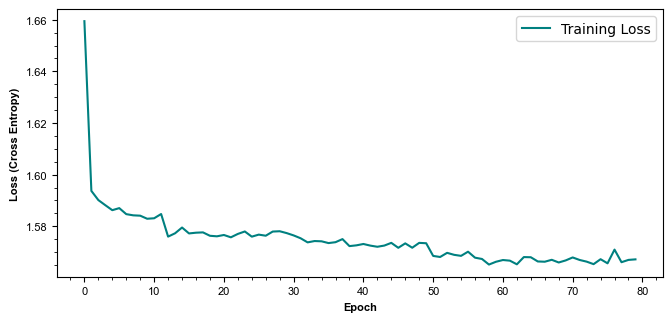

In [20]:
trainer.plotLosses( trainLosses,None )

[INFO]......... Testing on: GPU, model NVIDIA GeForce RTX 4070 Laptop GPU
[INFO]......... Checkpoint loaded successfully. Resuming training...
[INFO]......... The scaler has been loaded successfully.
[WARNING]......... The block weight for the ANNOTATED_TRIP_TRIP_OUT_5632_NOSTUCK well was not provided. Therefore, it has been inferred. Its value is: 48.4
[INFO]......... Block weight for ANNOTATED_TRIP_TRIP_OUT_5632_NOSTUCK.csv has been set on: 48.4 klb.
[INFO]......... Data has been loaded correctly to the trainer. In total, 1 dataframes have been loaded.
[INFO]......... The testing dataset has the following shape: 6809 X 10. The response: (6809, 11).
[INFO]......... Accuracy: 0.9067
[DEBUG]......... locator: <matplotlib.ticker.AutoLocator object at 0x000002F535A4E4D0>
[WARNING]......... The number of classes has been inferred from the confusion matrix: 11
[INFO]......... [RESULTS] -------->  Class Tripping in on elevators: Precision=0.00, Recall=0.00, F1 Score=0.00
[INFO]......... [RES

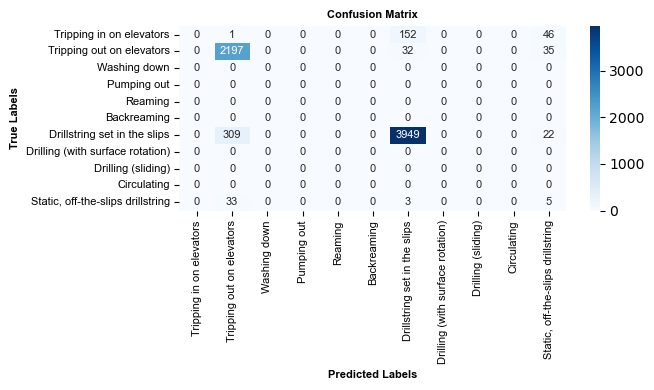

In [67]:
trainer=Trainer(  )
preds,dfTraining = trainer.testModel( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp5",
                  pathScaler=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\LSTM_H150\scaler_transformer_SW5_30_SW5_30CV15_H150_L5.pkl",
                  # modelType='lstm',
                  modelType='lstm',
                  loadFromPath=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\LSTM_H150\lstm_H150_L5_SW5_30_SWC15_CV15",
                  slidingWindow=[5,30],
                  slidingWindowCoverage=15,
                  nInputs=10,
                  nLayers=5,
                  # nHeads=8,
                  nHidden=150,
                  # blockWeights={"TRIP_IN_5632_NOSTUCK":46}
                    )

In [68]:
dfTraining

,Date,Hole Depth [ft],Bit Depth [ft],ROP [fph],Surface Rotation [rpm],Standpipe Pressure [psi],Torque [lb-ft],Hook Load [klb],Flow In [gpm],Block Position [ft],...,Short-Term Block Position Trend,Long-Term Block Position Trend,Hook Load Mean,Short-Term Effective Hook Load Trend,Long-Term Effective Hook Load Trend,Flow Rate Variability,Flow Rate Mean,Standpipe Pressure Mean,RPM Mean,ROP Mean
29,2021-02-22 16:15:31,7627.8,7601.5,0.0,24.51,0.0,0.528,47.2,0.0,117.6,...,0.00,-1.843705e-15,-1.268,2.000000e-02,-0.003115,0.0,0.0,0.0,24.51,0.0
30,2021-02-22 16:15:32,7627.8,7601.5,0.0,24.51,0.0,0.533,47.1,0.0,117.6,...,0.00,-1.843705e-15,-1.268,1.000000e-02,-0.003315,0.0,0.0,0.0,24.51,0.0
31,2021-02-22 16:15:33,7627.8,7601.5,0.0,24.51,0.0,0.528,47.1,0.0,117.6,...,0.00,-1.843705e-15,-1.268,-1.216188e-16,-0.003471,0.0,0.0,0.0,24.51,0.0
32,2021-02-22 16:15:34,7627.8,7601.5,0.0,24.51,0.0,0.528,47.2,0.0,117.6,...,0.00,-1.843705e-15,-1.248,1.000000e-02,-0.002937,0.0,0.0,0.0,24.51,0.0
33,2021-02-22 16:15:35,7627.8,7601.5,0.0,24.51,0.0,0.533,47.2,0.0,117.6,...,0.00,-1.843705e-15,-1.228,1.000000e-02,-0.002403,0.0,0.0,0.0,24.51,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6833,2021-02-22 18:08:55,7627.8,1590.3,0.0,0.00,0.0,0.000,98.7,0.0,131.6,...,0.96,3.840245e+00,48.352,1.400000e-01,0.405428,0.0,0.0,0.0,0.00,0.0
6834,2021-02-22 18:08:56,7627.8,1590.9,0.0,0.00,0.0,0.000,102.6,0.0,131.2,...,0.26,3.816685e+00,49.272,1.690000e+00,0.123448,0.0,0.0,0.0,0.00,0.0
6835,2021-02-22 18:08:57,7627.8,1591.2,0.0,0.00,0.0,0.000,98.9,0.0,130.6,...,-0.20,3.751079e+00,49.912,1.350000e+00,-0.155773,0.0,0.0,0.0,0.00,0.0
6836,2021-02-22 18:08:58,7627.8,1591.2,0.0,0.00,0.0,0.000,52.1,0.0,130.4,...,-0.34,3.650679e+00,41.212,-8.700000e+00,-0.410234,0.0,0.0,0.0,0.00,0.0


In [69]:
dfTraining

,Date,Hole Depth [ft],Bit Depth [ft],ROP [fph],Surface Rotation [rpm],Standpipe Pressure [psi],Torque [lb-ft],Hook Load [klb],Flow In [gpm],Block Position [ft],...,Short-Term Block Position Trend,Long-Term Block Position Trend,Hook Load Mean,Short-Term Effective Hook Load Trend,Long-Term Effective Hook Load Trend,Flow Rate Variability,Flow Rate Mean,Standpipe Pressure Mean,RPM Mean,ROP Mean
29,2021-02-22 16:15:31,7627.8,7601.5,0.0,24.51,0.0,0.528,47.2,0.0,117.6,...,0.00,-1.843705e-15,-1.268,2.000000e-02,-0.003115,0.0,0.0,0.0,24.51,0.0
30,2021-02-22 16:15:32,7627.8,7601.5,0.0,24.51,0.0,0.533,47.1,0.0,117.6,...,0.00,-1.843705e-15,-1.268,1.000000e-02,-0.003315,0.0,0.0,0.0,24.51,0.0
31,2021-02-22 16:15:33,7627.8,7601.5,0.0,24.51,0.0,0.528,47.1,0.0,117.6,...,0.00,-1.843705e-15,-1.268,-1.216188e-16,-0.003471,0.0,0.0,0.0,24.51,0.0
32,2021-02-22 16:15:34,7627.8,7601.5,0.0,24.51,0.0,0.528,47.2,0.0,117.6,...,0.00,-1.843705e-15,-1.248,1.000000e-02,-0.002937,0.0,0.0,0.0,24.51,0.0
33,2021-02-22 16:15:35,7627.8,7601.5,0.0,24.51,0.0,0.533,47.2,0.0,117.6,...,0.00,-1.843705e-15,-1.228,1.000000e-02,-0.002403,0.0,0.0,0.0,24.51,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6833,2021-02-22 18:08:55,7627.8,1590.3,0.0,0.00,0.0,0.000,98.7,0.0,131.6,...,0.96,3.840245e+00,48.352,1.400000e-01,0.405428,0.0,0.0,0.0,0.00,0.0
6834,2021-02-22 18:08:56,7627.8,1590.9,0.0,0.00,0.0,0.000,102.6,0.0,131.2,...,0.26,3.816685e+00,49.272,1.690000e+00,0.123448,0.0,0.0,0.0,0.00,0.0
6835,2021-02-22 18:08:57,7627.8,1591.2,0.0,0.00,0.0,0.000,98.9,0.0,130.6,...,-0.20,3.751079e+00,49.912,1.350000e+00,-0.155773,0.0,0.0,0.0,0.00,0.0
6836,2021-02-22 18:08:58,7627.8,1591.2,0.0,0.00,0.0,0.000,52.1,0.0,130.4,...,-0.34,3.650679e+00,41.212,-8.700000e+00,-0.410234,0.0,0.0,0.0,0.00,0.0


In [70]:
len(preds)

6784

In [64]:
np.savetxt( "predictions_5632trip.csv",preds )

[INFO]......... Testing on: GPU, model NVIDIA GeForce RTX 4070 Laptop GPU
c:\Users\abrah\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[INFO]......... Checkpoint loaded successfully. Resuming training...
[INFO]......... The scaler has been loaded successfully.
[WARNING]......... The block weight for the labeled_testing_5632_11272024_2142 well was not provided. Therefore, it has been inferred. Its value is: 48.4
[INFO]......... Block weight for labeled_testing_5632_11272024_2142.csv has been set on: 48.4 klb.
[INFO]......... Data has been loaded correctly to the trainer. In total, 1 dataframes have been loaded.
[INFO]......... The testing dataset has the following 

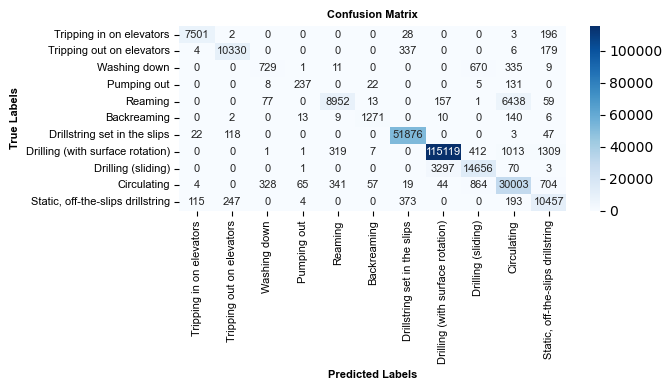

In [ ]:
trainer=Trainer(  )
preds,dfTraining = trainer.testModel( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp3",
                  pathScaler=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\TRANSFORMERS_HUGE_BATCH\scaler_transformer_SW230_WC60_H8_L6.pkl",
                  # modelType='lstm',
                  modelType='transformer',
                  loadFromPath=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\TRANSFORMERS_HUGE_BATCH\transformer_H8_L6_SW230_SWC60_CV60",
                  slidingWindow=[2,30],
                  slidingWindowCoverage=60,
                  nInputs=10,
                  nLayers=6,
                  nHeads=8,
                  # nHidden=150
                    )

[INFO]......... Testing on: GPU, model NVIDIA GeForce RTX 4070 Laptop GPU
[INFO]......... Checkpoint loaded successfully. Resuming training...
[INFO]......... The scaler has been loaded successfully.
[WARNING]......... The block weight for the labeled_testing_5632_11272024_2142 well was not provided. Therefore, it has been inferred. Its value is: 48.4
[INFO]......... Block weight for labeled_testing_5632_11272024_2142.csv has been set on: 48.4 klb.
[INFO]......... Data has been loaded correctly to the trainer. In total, 1 dataframes have been loaded.
[INFO]......... The testing dataset has the following shape: 270067 X 10. The response: (270067, 11).
[INFO]......... Accuracy: 0.9272
[DEBUG]......... locator: <matplotlib.ticker.AutoLocator object at 0x00000218E5183890>
[WARNING]......... The number of classes has been inferred from the confusion matrix: 11
[INFO]......... [RESULTS] -------->  Class Tripping in on elevators: Precision=0.99, Recall=0.97, F1 Score=0.98
[INFO]......... [RES

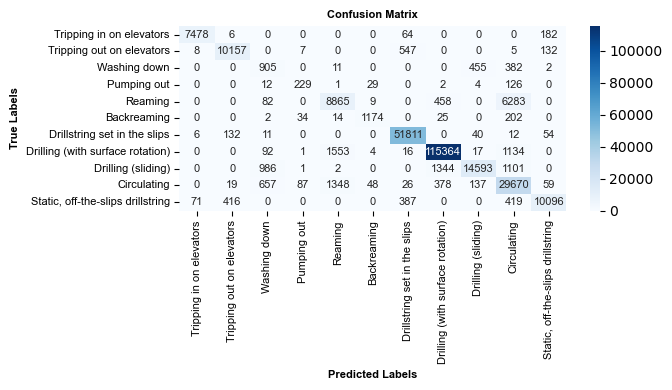

In [240]:
trainer=Trainer(  )
preds = trainer.testModel( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp3",
                  pathScaler=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\LSTM_CONV_H100\scaler_transformer_SW530_WC60_H100_L5.pkl",
                  # modelType='lstm',
                  modelType='conv_lstm',
                  loadFromPath=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\LSTM_CONV_H100\conv_lstm_H100_L5_SW530_SWC60_CV60",
                  slidingWindow=[5,30],
                  slidingWindowCoverage=60,
                  nInputs=10,
                  nLayers=5,
                  nHidden=100
                    )

[INFO]......... Testing on: GPU, model NVIDIA GeForce RTX 4070 Laptop GPU
c:\Users\abrah\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
[INFO]......... Checkpoint loaded successfully. Resuming training...
[INFO]......... The scaler has been loaded successfully.
[WARNING]......... The block weight for the labeled_testing_5632_11272024_2142 well was not provided. Therefore, it has been inferred. Its value is: 48.4
[INFO]......... Block weight for labeled_testing_5632_11272024_2142.csv has been set on: 48.4 klb.
[INFO]......... Data has been loaded correctly to the trainer. In total, 1 dataframes have been loaded.
[INFO]......... The testing dataset has the following 

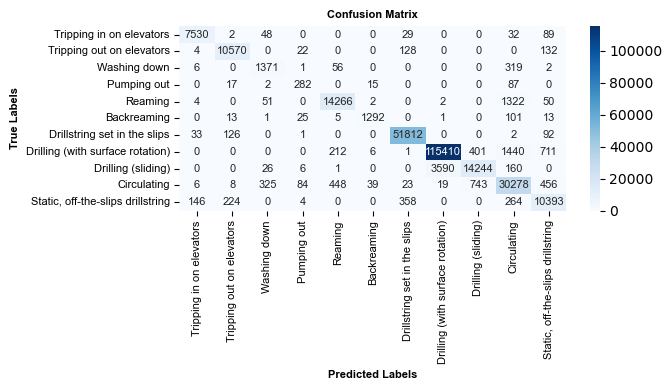

In [29]:
trainer=Trainer(  )
preds = trainer.testModel( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp3",
                  pathScaler=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\CONV TRANSFORMERS\scaler_transformer_SW251030_WC60_default_hiddens_L6.pkl",
                  # modelType='lstm',
                  modelType='conv_transformer',
                  loadFromPath=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\CONV TRANSFORMERS\conv_transformer_default_hiddens_L6_SW251030_SWC60_CV60",
                  slidingWindow=[2,5,10,30],
                  slidingWindowCoverage=60,
                  nInputs=14,
                  nLayers=6,
                  nHeads=8
                    )

## Time Profiling

In [145]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import random as rd
trainer=Trainer(  )
exerpts = [  ]
df = pd.read_csv( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp3\labeled_testing_5632_11272024_2142.csv",parse_dates=["Date"] )
df['Block Weight [klb]'] = 47.0
for i in range(100):
    idx = rd.randint( 0,270034 )
    exerpts.append( df.iloc[idx:idx+30] )
performancesHeavyTransformer                    = [  ]

for k,ex in enumerate( exerpts ):
    print( f"[PROGRESS].......Working on exerpt No. {k}" )
    pHFunc = lambda: trainer.testModel( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp3",
                                   preloadedDF=ex,
                                   pathScaler=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\TRANSFORMER_FOUR_SLIDING_WINDOWS\scaler_transformer_SW251030_WC300_default_hiddens_L3.pkl",
                                   modelType='transformer',
                                   loadFromPath=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\TRANSFORMER_FOUR_SLIDING_WINDOWS\transformer_default_hiddens_L3_SW251030_SWC300_CV300",
                                   slidingWindow=[2,5,10,30],
                                   slidingWindowCoverage=300,
                                   nInputs=14,
                                   nLayers=3,
                                   nHeads=8,
                                   profilingTime=True  )
    time = %timeit -o (pHFunc)(  )
    performancesHeavyTransformer.append( time.average )

In [ ]:
import random as rd
trainer=Trainer(  )
exerpts = [  ]
df = pd.read_csv( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp3\labeled_testing_5632_11272024_2142.csv",parse_dates=["Date"] )
df['Block Weight [klb]'] = 47.0
for i in range(100):
    idx = rd.randint( 0,270034 )
    exerpts.append( df.iloc[idx:idx+30] )
performancesLightransformer                    = [  ]

for ex in exerpts:
    pHFunc = lambda: trainer.testModel( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp3",
                                   preloadedDF=ex,
                                   pathScaler=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\TRANSFORMER_W1_5_W2_30_L3H8WC15E80\scaler_transformer_CV15.pkl",
                                   modelType='transformer',
                                   loadFromPath=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\TRANSFORMER_W1_5_W2_30_L3H8WC15E80\transformer_transformer_checkpoint.chpt_CV15",
                                   slidingWindow=[5,30],
                                   slidingWindowCoverage=15,
                                   nInputs=10,
                                   nLayers=3,
                                   nHeads=8,
                                   profilingTime=True  )
    time = %timeit -o (pHFunc)(  )
    performancesLightransformer.append( time.average )

In [163]:
pfs1 = pd.DataFrame(  )
pfs1['Performance']    =   performancesLightransformer
pfs1[ 'type' ]         = 'Light Transformer'
pfs2 = pd.DataFrame(  )
pfs2['Performance']    =   performancesHeavyTransformer
pfs2[ 'type' ]         = 'Heavy Transformer'
pfs             = pd.concat( [pfs1,pfs2],axis=0 )

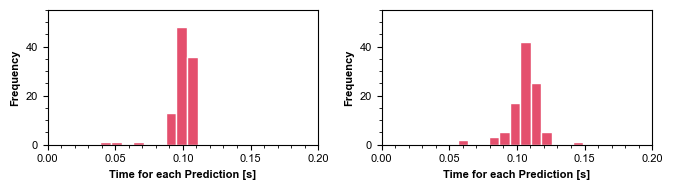

In [213]:
def plotDistributionTime( performanceMeansDF ):
    import matplotlib.pyplot as plt
    from matplotlib.ticker import (MultipleLocator,AutoMinorLocator)
    import seaborn as sb
    fdict                   = dict( family="Arial",size=8 )
    fig,axs                  = plt.subplots( 1,2,figsize=(6.83,2) ) #Size SPE papers 
    pal                     = [ "red","darkblue" ]
    sb.histplot( data=performanceMeansDF[performanceMeansDF['type']=='Light Transformer'],x="Performance",ax=axs[0],binwidth=0.008,color="crimson",edgecolor="w" );
    sb.histplot( data=performanceMeansDF[performanceMeansDF['type']=='Heavy Transformer'],x="Performance",ax=axs[1],binwidth=0.008,color="crimson",edgecolor="w" );
    for ax in axs:
        ax.set_xlim( 0,0.2 )
        ax.set_ylim( 0,55 )
        ax.set_xlabel( "Time for each Prediction [s]",fontdict={**fdict,"weight":"bold"} )
        ax.set_ylabel( "Frequency",fontdict={**fdict,"weight":"bold"} )
        ax.set_xticklabels( ax.get_xticklabels(  ),fontdict=fdict )
        ax.set_yticklabels( ax.get_yticklabels(  ),fontdict=fdict )
        ax.xaxis.set_minor_locator( AutoMinorLocator( ) )
        ax.yaxis.set_minor_locator( AutoMinorLocator( ) )
        labels=[ "Light Model","Parameter-Rich Model" ]
        # ax.legend( labels,prop=dict( size=8,family="Arial" ) )
    
    plt.tight_layout(  )
    fig.savefig( "histogramTimesTransformers.png",dpi=600 )

plotDistributionTime( pfs )

In [ ]:
import random as rd
trainer=Trainer(  )
exerpts = [  ]
df = pd.read_csv( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp3\labeled_testing_5632_11272024_2142.csv",parse_dates=["Date"] )
df['Block Weight [klb]'] = 47.0
for i in range(100):
    idx = rd.randint( 0,270034 )
    exerpts.append( df.iloc[idx:idx+30] )
performancesLightLSTM                    = [  ]

for k,ex in enumerate( exerpts ):
    print( f"[PROGRESS].......Working on exerpt No. {k}" )
    pHFunc = lambda: trainer.testModel( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp3",
                                   preloadedDF=ex,
                                   pathScaler=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\LSTM H30\scaler_transformer_SW5_30_SW5_30CV30_H30_L3.pkl",
                                   modelType='lstm',
                                   loadFromPath=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\LSTM H30\lstm_H30_L3_SW5_30_SWC30_CV30",
                                   slidingWindow=[5,30],
                                   slidingWindowCoverage=30,
                                   nInputs=10,
                                   nLayers=3,
                                   nHiddens=30,
                                   profilingTime=True  )
    time = %timeit -o (pHFunc)(  )
    performancesLightLSTM.append( time.average )

In [8]:
import random as rd
trainer=Trainer(  )
exerpts = [  ]
df = pd.read_csv( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp3\labeled_testing_5632_11272024_2142.csv",parse_dates=["Date"] )
df['Block Weight [klb]'] = 47.0
for i in range(100):
    idx = rd.randint( 0,270034 )
    exerpts.append( df.iloc[idx:idx+30] )
performancesHeavyLSTM                    = [  ]

for k,ex in enumerate( exerpts ):
    print( f"[PROGRESS].......Working on exerpt No. {k}" )
    pHFunc = lambda: trainer.testModel( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp3",
                                   preloadedDF=ex,
                                   pathScaler=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\LSTM_H150\scaler_transformer_SW5_30_SW5_30CV30_H150_L5.pkl",
                                   modelType='lstm',
                                   loadFromPath=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\LSTM_H150\lstm_H150_L5_SW5_30_SWC30_CV30",
                                   slidingWindow=[5,30],
                                   slidingWindowCoverage=30,
                                   nInputs=10,
                                   nLayers=5,
                                   nHidden=150,
                                   profilingTime=True  )
    time = %timeit -o (pHFunc)(  )
    performancesHeavyLSTM.append( time.average )

[INFO]......... Testing on: GPU, model NVIDIA GeForce RTX 4070 Laptop GPU
[INFO]......... Checkpoint loaded successfully. Resuming training...
[INFO]......... The scaler has been loaded successfully.
[INFO]......... Loaded provided dataframe sucessfully.
C:\Users\abrah\AppData\Local\Temp\ipykernel_15548\2580585085.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.nom.EFF_HOOK_LOAD_MNEMO]            = np.where(df[self.nom.HOOK_LOAD_MNEMO]>0,df[self.nom.HOOK_LOAD_MNEMO]-df[self.nom.BLOCK_WEIGHT_MNEMO],0)
C:\Users\abrah\AppData\Local\Temp\ipykernel_15548\2580585085.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

[PROGRESS].......Working on exerpt No. 0


[INFO]......... Checkpoint loaded successfully. Resuming training...
[INFO]......... The scaler has been loaded successfully.
[INFO]......... Loaded provided dataframe sucessfully.
C:\Users\abrah\AppData\Local\Temp\ipykernel_15548\2580585085.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.nom.EFF_HOOK_LOAD_MNEMO]            = np.where(df[self.nom.HOOK_LOAD_MNEMO]>0,df[self.nom.HOOK_LOAD_MNEMO]-df[self.nom.BLOCK_WEIGHT_MNEMO],0)
C:\Users\abrah\AppData\Local\Temp\ipykernel_15548\2580585085.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

50.1 ms ± 2.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[PROGRESS].......Working on exerpt No. 1


[INFO]......... Testing on: GPU, model NVIDIA GeForce RTX 4070 Laptop GPU
[INFO]......... Checkpoint loaded successfully. Resuming training...
[INFO]......... The scaler has been loaded successfully.
[INFO]......... Loaded provided dataframe sucessfully.
C:\Users\abrah\AppData\Local\Temp\ipykernel_15548\2580585085.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.nom.EFF_HOOK_LOAD_MNEMO]            = np.where(df[self.nom.HOOK_LOAD_MNEMO]>0,df[self.nom.HOOK_LOAD_MNEMO]-df[self.nom.BLOCK_WEIGHT_MNEMO],0)
C:\Users\abrah\AppData\Local\Temp\ipykernel_15548\2580585085.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

KeyboardInterrupt: 

In [217]:
pfs1 = pd.DataFrame(  )
pfs1['Performance']    =   performancesLightLSTM
pfs1[ 'type' ]         = 'Light LSTM'
pfs2 = pd.DataFrame(  )
pfs2['Performance']    =   performancesHeavyLSTM
pfs2[ 'type' ]         = 'Heavy LSTM'
pfs             = pd.concat( [pfs1,pfs2],axis=0 )

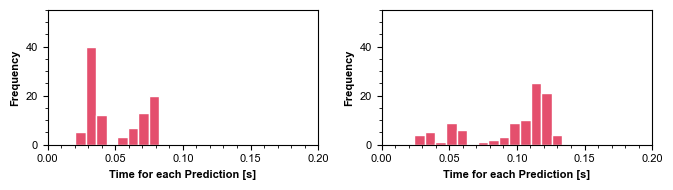

In [219]:
def plotDistributionTime( performanceMeansDF ):
    import matplotlib.pyplot as plt
    from matplotlib.ticker import (MultipleLocator,AutoMinorLocator)
    import seaborn as sb
    fdict                   = dict( family="Arial",size=8 )
    fig,axs                  = plt.subplots( 1,2,figsize=(6.83,2) ) #Size SPE papers 
    pal                     = [ "red","darkblue" ]
    sb.histplot( data=performanceMeansDF[performanceMeansDF['type']=='Light LSTM'],x="Performance",ax=axs[0],binwidth=0.008,color="crimson",edgecolor="w" );
    sb.histplot( data=performanceMeansDF[performanceMeansDF['type']=='Heavy LSTM'],x="Performance",ax=axs[1],binwidth=0.008,color="crimson",edgecolor="w" );
    for ax in axs:
        ax.set_xlim( 0,0.2 )
        ax.set_ylim( 0,55 )
        ax.set_xlabel( "Time for each Prediction [s]",fontdict={**fdict,"weight":"bold"} )
        ax.set_ylabel( "Frequency",fontdict={**fdict,"weight":"bold"} )
        ax.set_xticklabels( ax.get_xticklabels(  ),fontdict=fdict )
        ax.set_yticklabels( ax.get_yticklabels(  ),fontdict=fdict )
        ax.xaxis.set_minor_locator( AutoMinorLocator( ) )
        ax.yaxis.set_minor_locator( AutoMinorLocator( ) )
        labels=[ "Light Model","Parameter-Rich Model" ]
        # ax.legend( labels,prop=dict( size=8,family="Arial" ) )
    
    plt.tight_layout(  )
    fig.savefig( "histogramTimesLSTMs.png",dpi=600 )

plotDistributionTime( pfs )

In [ ]:
import random as rd
trainer=Trainer(  )
exerpts = [  ]
df = pd.read_csv( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp3\labeled_testing_5632_11272024_2142.csv",parse_dates=["Date"] )
df['Block Weight [klb]'] = 47.0
for i in range(100):
    idx = rd.randint( 0,270034 )
    exerpts.append( df.iloc[idx:idx+30] )
performancesConvLSTM                    = [  ]

for k,ex in enumerate( exerpts ):
    print( f"[PROGRESS].......Working on exerpt No. {k}" )
    pHFunc = lambda: trainer.testModel( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp3",
                  pathScaler=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\LSTM_CONV_H100\scaler_transformer_SW530_WC60_H100_L5.pkl",
                  # modelType='lstm',
                  modelType='conv_lstm',
                  preloadedDF=ex,
                  loadFromPath=r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\3. CHECKPOINTS\Stratified Models\LSTM_CONV_H100\conv_lstm_H100_L5_SW530_SWC60_CV60",
                  slidingWindow=[5,30],
                  slidingWindowCoverage=60,
                  nInputs=10,
                  nLayers=5,
                  nHidden=100,
                  profilingTime=True
                    )
    time = %timeit -o (pHFunc)(  )
    performancesConvLSTM.append( time.average )


In [11]:
pfs1 = pd.DataFrame(  )
pfs1['Performance']    =   performancesConvLSTM
pfs1[ 'type' ]         = 'Conv LSTM'

C:\Users\abrah\AppData\Local\Temp\ipykernel_6480\3668802059.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( ax.get_xticklabels(  ),fontdict=fdict )
C:\Users\abrah\AppData\Local\Temp\ipykernel_6480\3668802059.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels( ax.get_yticklabels(  ),fontdict=fdict )


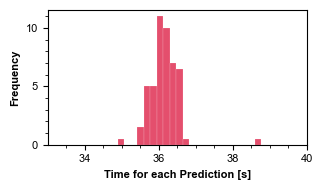

In [ ]:
def plotDistributionTime( performanceMeansDF ):
    import matplotlib.pyplot as plt
    from matplotlib.ticker import (MultipleLocator,AutoMinorLocator)
    import seaborn as sb
    fdict                   = dict( family="Arial",size=8 )
    fig,ax                  = plt.subplots( figsize=(3.33,2) ) #Size SPE papers 
    pal                     = [ "red","darkblue" ]
    sb.histplot( data=performanceMeansDF[(performanceMeansDF['type']=='Conv LSTM') & (performanceMeansDF['Performance']<100) ],x="Performance",ax=ax,color="crimson",edgecolor="w" );
    ax.set_xlim( 33,40 )
    # ax.set_ylim( 0,55 )
    ax.set_xlabel( "Time for each Prediction [s]",fontdict={**fdict,"weight":"bold"} )
    ax.set_ylabel( "Frequency",fontdict={**fdict,"weight":"bold"} )
    ax.set_xticklabels( ax.get_xticklabels(  ),fontdict=fdict )
    ax.set_yticklabels( ax.get_yticklabels(  ),fontdict=fdict )
    ax.xaxis.set_minor_locator( AutoMinorLocator( ) )
    ax.yaxis.set_minor_locator( AutoMinorLocator( ) )
    labels=[ "Light Model","Parameter-Rich Model" ]
        # ax.legend( labels,prop=dict( size=8,family="Arial" ) )
    
    plt.tight_layout(  )
    fig.savefig( "histogramTimesConvLSTMs2.png",dpi=600 )

plotDistributionTime( pfs1 )

C:\Users\abrah\AppData\Local\Temp\ipykernel_15548\1665918992.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( ax.get_xticklabels(  ),fontdict=fdict )
C:\Users\abrah\AppData\Local\Temp\ipykernel_15548\1665918992.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels( ax.get_yticklabels(  ),fontdict=fdict )


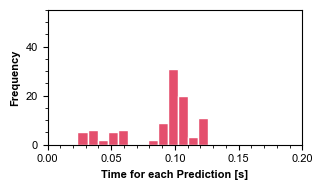

In [15]:
def plotDistributionTime( performanceMeansDF ):
    import matplotlib.pyplot as plt
    from matplotlib.ticker import (MultipleLocator,AutoMinorLocator)
    import seaborn as sb
    fdict                   = dict( family="Arial",size=8 )
    fig,ax                  = plt.subplots( figsize=(3.33,2) ) #Size SPE papers 
    pal                     = [ "red","darkblue" ]
    sb.histplot( data=performanceMeansDF[(performanceMeansDF['type']=='Conv LSTM') & (performanceMeansDF['Performance']<100) ],binwidth=0.008,x="Performance",ax=ax,color="crimson",edgecolor="w" );
    ax.set_xlim( 0,0.2 )
    ax.set_ylim( 0,55 )
    ax.set_xlabel( "Time for each Prediction [s]",fontdict={**fdict,"weight":"bold"} )
    ax.set_ylabel( "Frequency",fontdict={**fdict,"weight":"bold"} )
    ax.set_xticklabels( ax.get_xticklabels(  ),fontdict=fdict )
    ax.set_yticklabels( ax.get_yticklabels(  ),fontdict=fdict )
    ax.xaxis.set_minor_locator( AutoMinorLocator( ) )
    ax.yaxis.set_minor_locator( AutoMinorLocator( ) )
    labels=[ "Light Model","Parameter-Rich Model" ]
        # ax.legend( labels,prop=dict( size=8,family="Arial" ) )
    
    plt.tight_layout(  )
    fig.savefig( "histogramTimesConvLSTMs2.png",dpi=600 )

plotDistributionTime( pfs1 )

In [39]:
timesIS=[0.005936418714242921,
 0.005741373428526068,
 0.005801835285674315,
 0.005773035428594865,
 0.005817684285700254,
 0.005748235714231019,
 0.005846846428591692,
 0.005769819428595448,
 0.006793987142903331,
 0.017525729999761097,
 0.02389352099999087,
 0.020160790000227278,
 0.024362879428580137,
 0.020621398571945195,
 0.02048517428587989,
 0.01939480285717374,
 0.021650297142748187,
 0.02558618099998317,
 0.02176608857158239,
 0.022586279999813996,
 0.019293464285770563,
 0.01924003285821527,
 0.01998297571429118,
 0.01963095857188039,
 0.0194918600006661,
 0.02036976571377766,
 0.025051514428508066,
 0.020193708570773846,
 0.025039190285647887,
 0.025152481428563727,
 0.01820885714218353,
 0.023922200571396386,
 0.017479180000373164,
 0.024564921999990472,
 0.020232407143755286,
 0.01820975714238427,
 0.024841668714278575,
 0.018496297142285456,
 0.018848217142762486,
 0.02448102700000163,
 0.01856124285758207,
 0.023922864857096493,
 0.01916021000028455,
 0.019846008571247305,
 0.021426152857436265,
 0.026002824285699586,
 0.021685012856947388,
 0.02228949714252459,
 0.020620747142986926,
 0.025471233571505374,
 0.02100288999998676,
 0.02183494000013785,
 0.021142389999918774,
 0.025093234714212095,
 0.025694692714356017,
 0.023367317143129184,
 0.025041186857270078,
 0.020265604286188527,
 0.01981627714246445,
 0.02054642571477286,
 0.019466544285283556,
 0.02251769228572292,
 0.005847240000023573,
 0.005987160142935213,
 0.0058207975714633774,
 0.01885756300005596,
 0.005921621571469586,
 0.011671612428576087,
 0.0058270687142586595,
 0.005943058285754108,
 0.0060128411429052776,
 0.0057748640000603955,
 0.0059686017142043316,
 0.005954756571445613,
 0.005972877857150576,
 0.005928443571444534,
 0.005747108857197288,
 0.005781128857093531,
 0.005770529000022049,
 0.00588387100005223,
 0.005672927000019367,
 0.005765945857108039,
 0.005844118999957572,
 0.0058579059999569185,
 0.005800908999933329,
 0.005802356571449699,
 0.00584481042855519,
 0.005849727285718213,
 0.005864933714245645,
 0.005918787714243601,
 0.005926139714346002,
 0.0058196935714139334,
 0.005792282142751251,
 0.005969428857123213,
 0.005832810857183566,
 0.005820924999965687,
 0.005801082714294483,
 0.005765818428564151,
 0.005766941714266847,
 0.005782799999953048]

In [40]:
pfs1 = pd.DataFrame(  )
pfs1['Performance']    =   timesIS
pfs1[ 'type' ]         = 'IS'

C:\Users\abrah\AppData\Local\Temp\ipykernel_27028\2322420408.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( ax.get_xticklabels(  ),fontdict=fdict )
C:\Users\abrah\AppData\Local\Temp\ipykernel_27028\2322420408.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels( ax.get_yticklabels(  ),fontdict=fdict )


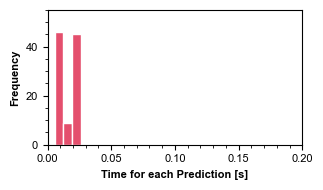

In [42]:
def plotDistributionTime( performanceMeansDF ):
    import matplotlib.pyplot as plt
    from matplotlib.ticker import (MultipleLocator,AutoMinorLocator)
    import seaborn as sb
    fdict                   = dict( family="Arial",size=8 )
    fig,ax                  = plt.subplots( figsize=(3.33,2) ) #Size SPE papers 
    pal                     = [ "red","darkblue" ]
    sb.histplot( data=performanceMeansDF[(performanceMeansDF['type']=='IS') & (performanceMeansDF['Performance']<100) ],binwidth=0.008,x="Performance",ax=ax,color="crimson",edgecolor="w" );
    ax.set_xlim( 0,0.2 )
    ax.set_ylim( 0,55 )
    ax.set_xlabel( "Time for each Prediction [s]",fontdict={**fdict,"weight":"bold"} )
    ax.set_ylabel( "Frequency",fontdict={**fdict,"weight":"bold"} )
    ax.set_xticklabels( ax.get_xticklabels(  ),fontdict=fdict )
    ax.set_yticklabels( ax.get_yticklabels(  ),fontdict=fdict )
    ax.xaxis.set_minor_locator( AutoMinorLocator( ) )
    ax.yaxis.set_minor_locator( AutoMinorLocator( ) )
    labels=[ "Light Model","Parameter-Rich Model" ]
        # ax.legend( labels,prop=dict( size=8,family="Arial" ) )
    
    plt.tight_layout(  )
    fig.savefig( "histogramTimesIS.png",dpi=600 )

plotDistributionTime( pfs1 )

## Measuring Accuracy of Inference System

In [22]:
def plotFancyContingencyTable(  confMatrix, classNames,outPath="contingency_table_IS.png"  ):
        FDICT_PLOTS                 = {'family':'Arial','size':8}
        fig, ax                 = plt.subplots(  figsize=(  6.83, 4  ))
        buff                    = sb.heatmap(  confMatrix, annot=True, fmt="d", cmap="Blues",
                        xticklabels=classNames, yticklabels=classNames, ax=ax, annot_kws={ **FDICT_PLOTS }  )
        ax.set_xlabel(  "Predicted Labels",fontdict={ **FDICT_PLOTS, 'weight':'bold' }  )
        ax.set_ylabel(  "True Labels",fontdict={ **FDICT_PLOTS, 'weight':'bold' }  )
        ax.set_title(  "Confusion Matrix",fontdict={ **FDICT_PLOTS, 'weight':'bold' }  )
        ax.set_xticklabels( ax.get_xticklabels( ), fontdict=FDICT_PLOTS )
        ax.set_yticklabels( ax.get_yticklabels( ), fontdict=FDICT_PLOTS )
        plt.tight_layout(  )
        fig.savefig( outPath,dpi=600 )

def printOutF1Scores( confMatrix,nClasses=None,classesNames=None ):
        if nClasses is None:
            nClasses                = confMatrix.shape[0]
            print( f"The number of classes has been inferred from the confusion matrix: {confMatrix.shape[0]}" )
        precScores      = [  ]
        recallScores    = [  ]
        f1Scores        = [  ]
        for i in range( nClasses ):
            TP = confMatrix[i, i]
            FP = confMatrix[:, i].sum( ) - TP
            FN = confMatrix[i, :].sum( ) - TP
            precision = TP / (TP + FP) if TP + FP > 0 else 0
            recall = TP / (TP + FN) if TP + FN > 0 else 0
            f1 = 2 * ( precision * recall ) / ( precision + recall ) if precision + recall > 0 else 0
            precScores.append(precision)
            recallScores.append(recall)
            f1Scores.append(f1)
        if classesNames is None:        classesNames = [ f"{i}" for i in range(len(f1Scores)) ]
        for i, (f1, precision, recall) in enumerate(zip( f1Scores, precScores, recallScores )):
            print( f"Class {classesNames[i]}: Precision={precision:.2f}, Recall={recall:.2f}, F1 Score={f1:.2f}" )
        return precScores,recallScores,f1Scores

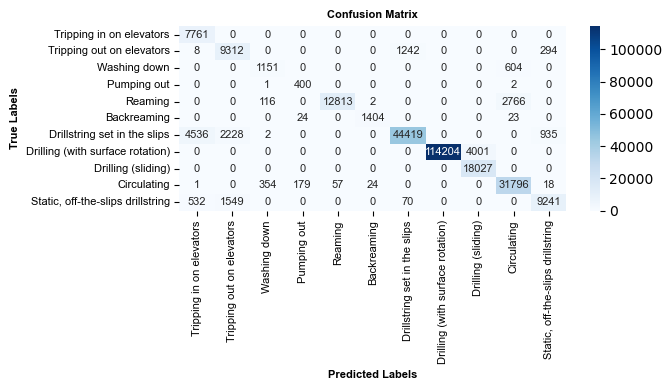

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy as sp
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
import sys
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
import joblib

dfTesting = pd.read_csv( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp3\labeled_testing_5632_11272024_2142.csv",parse_dates=["Date"],date_format="%Y-%m-%d %H:%M:%S" )
dfInitial = pd.read_csv( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\1. ANNOTATED DATA\ANNOTATED_5632.csv",parse_dates=["Date"],date_format="%Y-%m-%d %H:%M:%S" )
dfInitial = dfInitial[dfInitial["Date"]<pd.to_datetime( "2021-02-26 01:00:08",format="%Y-%m-%d %H:%M:%S" )]
dfInitial = dfInitial[dfInitial["Date"]>pd.to_datetime( "2021-02-22 01:00:08",format="%Y-%m-%d %H:%M:%S" )]
dfInitial = dfInitial[dfInitial["Date"].isin(dfTesting["Date"])]
yTrue = dfTesting['Rig State'].values
yPred = dfInitial['Rig State'].values
# print( f"The size of the arrays are: yTrue: {len(yTrue)}, yPred: {len(yPred)}" )
labelCodes = [111,112,114,115,116,117,118,119,120,121,124]
DICT_RIG_STATES         = {
                                    111:"Tripping in on elevators",
                                    112:"Tripping out on elevators",
                                    114:"Washing down",
                                    115:"Pumping out",
                                    116:"Reaming",
                                    117:"Backreaming",
                                    118:"Drillstring set in the slips",
                                    119:"Drilling (with surface rotation)",
                                    120:"Drilling (sliding)",
                                    121:"Circulating",
                                    124:"Static, off-the-slips drillstring"
                                }
labels = [ DICT_RIG_STATES[x] for x in labelCodes ]
cm = confusion_matrix(  yTrue, yPred, labels=labelCodes  )
plotFancyContingencyTable(cm,labels)

In [24]:
printOutF1Scores( cm,nClasses=None,classesNames=labels )

The number of classes has been inferred from the confusion matrix: 11
Class Tripping in on elevators: Precision=0.60, Recall=1.00, F1 Score=0.75
Class Tripping out on elevators: Precision=0.71, Recall=0.86, F1 Score=0.78
Class Washing down: Precision=0.71, Recall=0.66, F1 Score=0.68
Class Pumping out: Precision=0.66, Recall=0.99, F1 Score=0.80
Class Reaming: Precision=1.00, Recall=0.82, F1 Score=0.90
Class Backreaming: Precision=0.98, Recall=0.97, F1 Score=0.97
Class Drillstring set in the slips: Precision=0.97, Recall=0.85, F1 Score=0.91
Class Drilling (with surface rotation): Precision=1.00, Recall=0.97, F1 Score=0.98
Class Drilling (sliding): Precision=0.82, Recall=1.00, F1 Score=0.90
Class Circulating: Precision=0.90, Recall=0.98, F1 Score=0.94
Class Static, off-the-slips drillstring: Precision=0.88, Recall=0.81, F1 Score=0.84


([0.6045334164200031,
  0.7114370845748338,
  0.708743842364532,
  0.6633499170812603,
  0.9955710955710956,
  0.9818181818181818,
  0.9713104896022392,
  1.0,
  0.8183675322317051,
  0.9035264698360376,
  0.8811022120518688],
 [1.0,
  0.8577745025792188,
  0.6558404558404558,
  0.9925558312655087,
  0.8162706249601834,
  0.9676085458304617,
  0.8522448196469685,
  0.9661520240260564,
  1.0,
  0.980480434179284,
  0.8111832865168539],
 [0.7535317248410117,
  0.7777824180413447,
  0.6812666469369636,
  0.7952286282306162,
  0.8970490426016033,
  0.9746615758417216,
  0.9078905683130473,
  0.9827846598023312,
  0.9001123455249032,
  0.9404318249038746,
  0.8446983546617916])

In [ ]:
import random as rd
trainer=Trainer(  )
exerpts = [  ]
df = pd.read_csv( r"C:\Users\abrah\OneDrive\Doctorate Petroleum Engineering\0A. RESEARCH PROJECT\16. RIG ACTIVITY ENGINE\0. DATA\temp3\labeled_testing_5632_11272024_2142.csv",parse_dates=["Date"] )
df['Block Weight [klb]'] = 47.0
for i in range(100):
    idx = rd.randint( 0,270034 )
    exerpts.append( df.iloc[idx:idx+30] )
performancesIS                    = [  ]
